# Trabalho Final
Neste trabalho, vamos buscar o reconhecimento dos dígitos da Linguagem de Sinais. Para tal, vamos nos utilizar de Modelos conhecidos de Deep Learning e também nos aventurar na criação de próprios.

------

## Imports

In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [17]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, Dense, Flatten
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

import inf619utils

# Dataset
O dataset é composto por 10 classes (dígitos de 0 a 9) com aproximadamente 205 imagens por classe. 
O conjunto foi dividido em 60% para treinamento, 15% para validação e 20% para teste.
As imagens estão divididas em blocos por classe.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [2]:
keras_model_file = 'keras_resnet.h5'

datasetDir = "./Dataset"
datasetDirSplitted = "./DatasetSplitted"
nbClasses = 10
input_shape = (224,224,3)
input_size = (224,224)

train_files = {}
val_files = {}
test_files = {}

train_files, val_files, test_files = inf619utils.splitData(datasetDir, nbClasses)

In [3]:
#plot the images from imgList
def plotImagesFromBatch(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])


# Se quiser visualizar algum bloco de imagens, descomentar as linhas abaixo
# inf619utils.plotImages(val_files)
# inf619utils.plotImages(train_files)
# inf619utils.plotImages(test_files)

## Definição do modelo 

In [4]:
model = ResNet50(input_shape=input_shape, classes=nbClasses, include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin


# Modificação do modelo 

In [5]:
# Escolher a camada que será o ponto de partida 
x = model.output

#print([layer.name for layer in squeezeNetModel.layers])
#print("\n\nFreeze layers up until ", squeezeNetModel.layers[-20].name)

for layer in model.layers:
    layer.trainable = True#        layer.trainable = False

x = Flatten()(x)
x = Dense(10, activation='softmax')(x)


# Não se esqueça de definir o nome modelo, onde baseSqueezeNetModel 
# é o modelo base da Squeeze que vc definiu ali em cima
model = Model(model.inputs, x, name='resnet_new_adam')
#model2 = Model(squeezeNetModel.inputs, x, name='squeezenet_new_adadelta')
#model3 = Model(squeezeNetModel.inputs, x, name='squeezenet_new_sgd')

# Treinamento do Modelo

In [6]:
#Definir tamanho do batch e número de épocas
batch_size = 12 #check RAM or GPU memory size
epochs = 30

In [7]:
from keras.optimizers import SGD, Adam
#Compile o modelo
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

import keras.callbacks as callbacks

tbCallBack = callbacks.TensorBoard(log_dir = "./logs_resnet")
tbEarly = callbacks.EarlyStopping(monitor='val_acc',min_delta=0,patience=3,verbose=0, mode='auto')
tbEarly100 = callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=3, mode='max')
tbModelChk = callbacks.ModelCheckpoint('.modelresnet_weights.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        datasetDirSplitted + '\\train',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        datasetDirSplitted + '\\val',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 1242 images belonging to 10 classes.
Found 309 images belonging to 10 classes.


In [10]:
#Fit nos dados
#Fit nos dados
hist = model.fit_generator(train_generator, 
                    steps_per_epoch= int(1242/batch_size), 
                    epochs = epochs,
                    validation_data = validation_generator,  
                    validation_steps = int(309/batch_size),
                    callbacks=[tbCallBack, tbEarly, tbEarly100, tbModelChk])

Epoch 1/30
103/103 [==============================] - 265s 3s/step - loss: 1.5313 - acc: 0.5591 - val_loss: 0.9026 - val_acc: 0.7600
Epoch 2/30
103/103 [==============================] - 267s 3s/step - loss: 0.7743 - acc: 0.8220 - val_loss: 0.4221 - val_acc: 0.8822
Epoch 3/30
103/103 [==============================] - 264s 3s/step - loss: 0.4317 - acc: 0.9142 - val_loss: 0.2324 - val_acc: 0.9428
Epoch 4/30
103/103 [==============================] - 265s 3s/step - loss: 0.2515 - acc: 0.9458 - val_loss: 0.1714 - val_acc: 0.9428
Epoch 5/30
103/103 [==============================] - 263s 3s/step - loss: 0.1881 - acc: 0.9604 - val_loss: 0.1439 - val_acc: 0.9630
Epoch 6/30
103/103 [==============================] - 264s 3s/step - loss: 0.1429 - acc: 0.9709 - val_loss: 0.1050 - val_acc: 0.9697
Epoch 7/30
103/103 [==============================] - 264s 3s/step - loss: 0.1141 - acc: 0.9733 - val_loss: 0.0470 - val_acc: 0.9933
Epoch 8/30
103/103 [==============================] - 264s 3s/step - 

In [11]:
model.save(keras_model_file)

In [12]:
del model

# Aplicação do Modelo no Conjunto de Testes

In [4]:
# Load Best weights saved
from keras.models import load_model

model = load_model(keras_model_file)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        datasetDirSplitted + '\\test',
        target_size=input_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=None)

Found 511 images belonging to 10 classes.


In [16]:
#Criação do generator p/ o conjunto de teste

#Teste
metrics = model.evaluate_generator(test_generator, 
                                   steps=511)

print("Test Loss ResNet---> ", metrics[0])
print("Test Accuracy ResNet---> ", metrics[1])    #Test is balanced, so Acc is normalized

Test Loss ResNet--->  0.06739992477037
Test Accuracy ResNet--->  0.9705446813478072


# Gerar matrix de confusão

In [8]:
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [9]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [14]:
len(test_generator.classes)

511

In [10]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.96      1.00      0.98        51
           3       1.00      0.94      0.97        51
           4       0.98      0.94      0.96        51
           5       0.98      1.00      0.99        51
           6       0.96      1.00      0.98        51
           7       0.98      0.96      0.97        51
           8       0.89      0.94      0.92        52
           9       0.96      0.92      0.94        51

   micro avg       0.97      0.97      0.97       511
   macro avg       0.97      0.97      0.97       511
weighted avg       0.97      0.97      0.97       511



In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_classes, predicted_classes)

array([[51,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 51,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 48,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 48,  1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 51,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 49,  2,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  1, 49,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4, 47]], dtype=int64)

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        51
           2       0.96      1.00      0.98        51
           3       1.00      0.94      0.97        51
           4       0.98      0.94      0.96        51
           5       0.98      1.00      0.99        51
           6       0.96      1.00      0.98        51
           7       0.98      0.96      0.97        51
           8       0.89      0.94      0.92        52
           9       0.96      0.92      0.94        51

   micro avg       0.97      0.97      0.97       511
   macro avg       0.97      0.97      0.97       511
weighted avg       0.97      0.97      0.97       511

Normalized confusion matrix
[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.   100.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.   100.     0.     0.     0.    

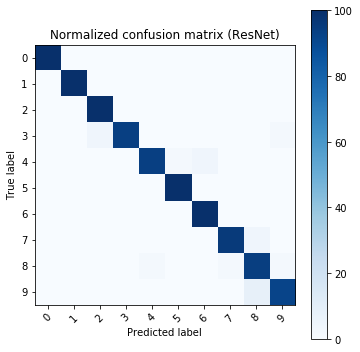

In [20]:
from inf619utils import plot_confusion

plot_confusion(true_classes, predicted_classes, "ResNet")

# Salvar modelo TensorflowJS (Linux)

In [ ]:
#import tensorflowjs as tfjs
#tfjs.converters.save_keras_model(model, tfjs_target_dir)

# Salvar modelo TensorflowLite (Linux)

In [ ]:
#from tensorflow.contrib import lite

#converter = lite.TocoConverter.from_keras_model_file(keras_model_file)
#tflite_model = converter.convert()
#open("resnet.tflite", "wb").write(tflite_model)